### status

Poboljsati svaku rutu tako da dobije bolji fitness<br>
Dinamicko menjanje prob parametra u generisanju ruta<br>
Konsultacije <br>
Potencijalno probati sa VNS-om ako ostane zivaca 

In [1]:
import random
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load(file):
    cities = []
    with open(file, 'r') as f:
        for line in f:
            data = line.split()
            city_num = int(data[0])-1
            x = float(data[1])
            y = float(data[2])
            demand = float(data[3])
            ready_time = float(data[4])
            due_time = float(data[5])
            
            city = {'city_num' : city_num, 'x' : x, 'y' : y, 'demand' : demand, 'ready_time' : ready_time, 'due_time' : due_time}
            cities.append(city)
            
    return cities   

In [3]:
input1 = load('resources/input_1.txt')
input2 = load('resources/input_2.txt')
input3 = load('resources/input_3.txt')

for x in input2:
    print(x)

{'city_num': 0, 'x': 40.0, 'y': 50.0, 'demand': 0.0, 'ready_time': 0.0, 'due_time': 1236.0}
{'city_num': 1, 'x': 45.0, 'y': 68.0, 'demand': 10.0, 'ready_time': 912.0, 'due_time': 967.0}
{'city_num': 2, 'x': 45.0, 'y': 70.0, 'demand': 30.0, 'ready_time': 825.0, 'due_time': 870.0}
{'city_num': 3, 'x': 42.0, 'y': 66.0, 'demand': 10.0, 'ready_time': 65.0, 'due_time': 146.0}
{'city_num': 4, 'x': 42.0, 'y': 68.0, 'demand': 10.0, 'ready_time': 727.0, 'due_time': 782.0}
{'city_num': 5, 'x': 42.0, 'y': 65.0, 'demand': 10.0, 'ready_time': 15.0, 'due_time': 67.0}
{'city_num': 6, 'x': 40.0, 'y': 69.0, 'demand': 20.0, 'ready_time': 621.0, 'due_time': 702.0}
{'city_num': 7, 'x': 40.0, 'y': 66.0, 'demand': 20.0, 'ready_time': 170.0, 'due_time': 225.0}
{'city_num': 8, 'x': 38.0, 'y': 68.0, 'demand': 20.0, 'ready_time': 255.0, 'due_time': 324.0}
{'city_num': 9, 'x': 38.0, 'y': 70.0, 'demand': 10.0, 'ready_time': 534.0, 'due_time': 605.0}
{'city_num': 10, 'x': 35.0, 'y': 66.0, 'demand': 10.0, 'ready_tim

In [4]:
class Individual:
    def __init__(self, data, capacity, num_of_vehicles, num_of_cities, service_time):
        self.num_of_vehicles = num_of_vehicles
        self.num_of_cities = num_of_cities
        self.depot = data[0]
        self.data = data
        self.distance_between_cities = self.calc_all_distances()
        self.capacity = capacity
        self.service_time = service_time
        self.time_penalty = 2
        self.capacity_penalty = 5
        self.tolerance = 1
        self.solution = self.initial_solution_nearest_neighbors()
        self.fitness = self.calc_fitness()

    def __len__(self) -> int:
        return len(self.solution)
    
    def calc_distance(self, city1, city2) -> float:
        distance = math.sqrt((city1["x"] - city2["x"])**2 + (city1["y"] - city2["y"])**2)
        return round(distance, 3)
    
    def calc_all_distances(self) -> [[float]]:
        all_distances = [[0 for _ in range(len(self.data))] for _ in range(len(self.data))]
        
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if i != j:
                    distance = self.calc_distance(self.data[i], self.data[j])
                    all_distances[i][j] = distance
                else:
                    all_distances[i][j] = 0
                
        return all_distances


    def initial_solution_nearest_neighbors(self):
        routes = [[] for _ in range(self.num_of_vehicles)]
        remaining_cities = [i for i in range(1, self.num_of_cities + 1)]
        
        return self.generate_solution_nearest_neighbors(routes, remaining_cities)
    
    def get_feasible_cities(self, remaining_cities, start_city, current_time, capacity):
            feasible_cities = [(next_city, round(max(self.distance_between_cities[start_city][next_city], 
                                       self.data[next_city]["ready_time"] - current_time - self.service_time), 3)) 
                               for next_city in remaining_cities \
                               if round(current_time + self.distance_between_cities[start_city][next_city] + \
                                        self.service_time, 3) <= 
                                  self.data[next_city]["due_time"] + self.tolerance and \
                                  capacity >= self.data[next_city]["demand"]]
            
            feasible_cities.sort(key = lambda x: x[1])
            return feasible_cities
    
    
    def generate_feasible_routes(self, routes, remaining_cities, prob_param) -> [[int]]: 
        for route in routes:
            while True:
                if not route:
                    feasible_cities = self.get_feasible_cities(remaining_cities, 0, 0, self.capacity)
                else:
                    _, current_time, remaining_capacity = self.route_fitness(route)
                    feasible_cities = self.get_feasible_cities(remaining_cities, route[-1], current_time, remaining_capacity)

                if not feasible_cities:
                    break
                    
                if random.random() < prob_param:
                    city_index = random.choice(feasible_cities)[0]
                else:
                    city_index = feasible_cities[0][0]

                remaining_cities.remove(city_index)
                route.append(city_index)

                is_unfeasible, _ = self.is_route_unfeasible(route)
                if is_unfeasible:
                    route.pop(-1)
                    remaining_cities.append(city_index)
                    continue
    
        if not remaining_cities:
            return routes
        
        # create an unfeasible route
        for route in routes:
            if not route:
                for city in remaining_cities:
                    route.append(city)
                    is_unfeasible, _ = self.is_route_unfeasible(route)
                    print('is unfeasible:', is_unfeasible)
                    if is_unfeasible:
                        route.pop(-1)
                        remaining_cities.append(city)
                        break 
        
        return routes
        
    def generate_solution_nearest_neighbors(self, routes, remaining_cities) -> [int]:        
        generated_routes = self.generate_feasible_routes(routes, remaining_cities, 0.7)
        return self.create_solution(generated_routes)

    def create_solution(self, routes) -> [int]:
        solution = []
        for i, route in enumerate(routes):
            for city in route:
                solution.append(city)
            solution.append(self.num_of_cities + i + 1)
        
        # remove empty routes
        for city in reversed(solution):
            if city > 100:
                solution.pop(-1)
            else:
                break
                
        return solution


    def is_route_unfeasible(self, route) -> (bool, int):
        if not route:
            return False, None
        
        current_time = 0
        previous_city = 0
        remaining_capacity = self.capacity 
        
        for current_city in route:
            current_city_data = self.data[current_city]
            distance = self.distance_between_cities[previous_city][current_city] 
            
            if round(current_time + distance + self.service_time, 3) > current_city_data["due_time"] + self.tolerance:
                # print('\ntime violation')
                # print('current time + distance + service time =:', round(current_time + distance + self.service_time, 3))
                # print('city due time + tolerance =', current_city_data["due_time"] + self.tolerance)
                # print('city that produced violation:', current_city)
                # print('in route: ', route)
                return True, current_city 
            
            elif remaining_capacity < current_city_data["demand"]:
                print('\ncapacity violation')
                print('city that produced violation:', current_city)
                print('in route: ', route)

                return True, current_city
                
            current_time += distance + self.service_time
            previous_city = current_city
            remaining_capacity -= current_city_data["demand"]
            
        # return to depot
        if round(current_time + self.distance_between_cities[previous_city][0] + self.service_time, 3) > \
           self.depot["due_time"] + self.tolerance:
            print('\ntime violation - return to depot')
            print('city that produced violation:', previous_city)
            return True, previous_city
        
        return False, None
    
    def route_fitness(self, route) -> (float, float, float):
        if not route:
            return 0, 0, self.capacity
        
        fitness = 0
        current_time = 0
        previous_city = 0
        remaining_capacity = self.capacity
        
        for current_city in route:
            current_city_data = self.data[current_city]
            distance = self.distance_between_cities[previous_city][current_city]
            
            if round(current_time + distance + self.service_time, 3) > current_city_data["due_time"]:
                fitness += (current_time + distance + self.service_time - current_city_data["due_time"])*self.time_penalty
                
            if remaining_capacity < current_city_data["demand"]:
                fitness += (current_city_data["demand"] - remaining_capacity)*self.capacity_penalty
                
            current_time += distance + self.service_time
            previous_city = current_city
            remaining_capacity -= current_city_data["demand"]
            
        fitness += current_time + self.distance_between_cities[previous_city][0] + self.service_time
        fitness /= len(route) #fitness normalization
        fitness = round(fitness, 3)
        
        return fitness, current_time, remaining_capacity
    
    def get_routes(self) -> [[int]]:
        routes = []
        route = []
        # all routes except for the last route
        for city_index in self.solution:
            if city_index <= self.num_of_cities:
                route.append(city_index)
            else:
                if len(route) > 0:
                    routes.append(route)
                route = []

        # last route
        if len(route) > 0:
            routes.append(route)

        return routes
    
    def calc_fitness(self) -> float:
        routes = self.get_routes()
        
        # more routes than available vehicles
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
            return float('inf')

        fitness = 0
        for route in routes:
            if len(route) == 0:
                continue
            f, _, _ = self.route_fitness(route)
            fitness += f
            
        return fitness

    def is_feasible(self) -> bool:
        visited = [False for _ in range(self.num_of_cities)]
        for c in self.solution:
            if c <= self.num_of_cities:
                if  not visited[c-1]:
                    visited[c-1] = True
                else:
#                     print("CUSTOMER ", c, "ALREADY VISITED!")
                    return False
        if not all(visited):
#             print("NOT ALL CUSTOMERS HAVE BEEN VISITED: ")
#             for i,v in enumerate(visited):
#                 if not v:
#                     print("\t", i)
            return False
        
        routes = self.get_routes()
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
#             print("more vehicles than available violation")
            return False

        for route in routes:
            is_unfeasible, _ = self.is_route_unfeasible(route)
            if is_unfeasible:
                return False
        
        return True
    
    def is_feasible_verbose(self) -> bool:
        visited = [False for _ in range(self.num_of_cities)]
        for c in self.solution:
            if c <= self.num_of_cities:
                if  not visited[c-1]:
                    visited[c-1] = True
                else:
                    print("CUSTOMER ", c, "ALREADY VISITED!")
                    return False
        if not all(visited):
            print("NOT ALL CUSTOMERS HAVE BEEN VISITED: ")
            for i,v in enumerate(visited):
                if not v:
                    print("\t", i)
            return False
        
        routes = self.get_routes()
        if sum(1 for r in routes if len(r) > 0) > self.num_of_vehicles:
            print("more vehicles than available violation")
            return False

        for route in routes:
            is_unfeasible, _ = self.is_route_unfeasible(route)
            if is_unfeasible:
                return False
        
        #print("Solution is feasible!")
        return True

In [5]:
x = Individual(input1, 200, 50, 100, 10)
print(x.solution)
print(x.is_feasible())

y = Individual(input1, 200, 50, 100, 10)
print(y.solution)
print(y.is_feasible())

[23, 25, 22, 4, 70, 101, 59, 30, 74, 13, 100, 102, 15, 80, 58, 17, 93, 103, 92, 95, 78, 35, 77, 104, 54, 9, 50, 3, 1, 89, 105, 56, 21, 73, 40, 37, 97, 91, 106, 86, 66, 32, 107, 52, 24, 79, 55, 108, 16, 7, 26, 68, 109, 6, 5, 43, 57, 96, 48, 110, 62, 31, 88, 20, 10, 60, 111, 69, 34, 71, 112, 49, 19, 8, 46, 113, 82, 51, 81, 114, 36, 84, 115, 28, 27, 99, 61, 85, 116, 90, 11, 117, 44, 41, 118, 72, 18, 94, 119, 42, 2, 87, 53, 120, 33, 67, 121, 75, 12, 122, 14, 38, 123, 65, 124, 45, 125, 76, 29, 126, 64, 127, 39, 128, 83, 98, 129, 47, 130, 63]
True
[5, 83, 1, 93, 13, 80, 101, 65, 71, 100, 89, 58, 102, 59, 90, 24, 25, 103, 87, 2, 56, 22, 70, 77, 104, 63, 35, 50, 68, 105, 92, 48, 96, 43, 91, 106, 82, 47, 97, 26, 4, 107, 23, 75, 6, 54, 108, 72, 21, 12, 57, 60, 109, 95, 10, 9, 66, 110, 79, 55, 3, 74, 111, 94, 27, 30, 37, 17, 112, 20, 88, 46, 113, 53, 28, 81, 34, 32, 114, 98, 7, 84, 115, 33, 29, 51, 116, 19, 62, 8, 117, 85, 78, 118, 44, 40, 119, 42, 18, 49, 120, 52, 76, 73, 121, 45, 99, 41, 122, 3

In [6]:
x.solution == y.solution

False

## Problem: Nedostižni gradovi

Gradovi 14, 36, 63, 92 predstavljaju nedopustiva rešenja.
Nemoguće ih je opslužiti u zadatom vremenskom roku ukoliko se krene od depoa, što je ujedno i početni trenutak svake rute. 

Kako za svaki grad dobijamo vremensko prekoračenje od početne tačke bilo koje rute, zaključujemo da su ti gradovi u potpunosti nedostižni i nije ih moguće obraditi u zadatom vremenskom roku.

## Rešenje: Postoji više mogućnosti

 - Prvo i intuitivno rešenje koje se nameće je da u potpunosti odbacimo navedene gradove i na dalje da posmatramo samo ostale, dostižne gradove koji proizvode dopustiva rešenja.
 
 - Drugo rešenje bi bilo da postavimo prag tolerancije na prekoračenje vremenskog roka. Ukoliko je prekoračeno vreme unutar praga tolerancije tada ćemo rešenje da smatramo dopustivim, ali uz penalizaciju fitness vrednosti.
 
 - Treće rešenje razmatra sve one gradove koji prekoračuju prag tolerancije nad vremenskim ograničenjem. Takva rešenja se smatraju nezadovoljivim i penalizuje se u odnosu na vreme zakašnjenja.

# Selection

In [7]:
def random_selection(population):
    return random.choice(population)

In [8]:
def tournament_selection(population, tournament_size):
    tournament = random.sample(population, tournament_size)
    return max(tournament, key = lambda x: x.fitness)

In [9]:
def roulette_selection(population):
    total_fitness = sum([individual.fitness for individual in population])
    selection_probs = [individual.fitness / total_fitness for individual in population]
    return random.choices(population, weights=selection_probs)[0]

In [10]:
def rang_selection(population):
    n = len(population)
    rang_sum = n * (n+1) / 2
    selection_probs = []
    for rang, _ in enumerate(sorted(population, key=lambda x: x.fitness), 1):
        selection_probs.append(rang / rang_sum)
        
    return random.choices(population, weights=selection_probs)[0]

In [11]:
def selection(param, population):
    if param["tournament_size"] is not None:
        return param["selection"](population, param["tournament_size"])
    else:
        return param["selection"](population)

In [12]:
class Example_Individual:
    def __init__(self, fitness, name):
        self.fitness = fitness
        self.name = name

example_population = [Example_Individual(fitness=0.8, name='A'), 
                      Example_Individual(fitness=0.6, name='B'), 
                      Example_Individual(fitness=0.7, name='C'),
                      Example_Individual(fitness=0.8, name='D'), 
                      Example_Individual(fitness=0.9, name='E')]

print(random_selection(example_population).name)
print(tournament_selection(example_population, 3).name)
print(roulette_selection(example_population).name)
print(rang_selection(example_population).name)

E
E
D
D


# Crossover

In [13]:
def order_crossover(parent1, parent2):
    min_len = min(len(parent1), len(parent2))

    def oc(p1, p2, lb, ub):
        ch = [None for _ in range(min_len)]
        ch[lb:ub] = p1[lb:ub]

        p2_index = ub
        ch_index = ub
        while None in ch:
            if ch_index == len(ch):
                ch_index = 0
            if p2_index == len(p2):
                p2_index = 0
            if p2[p2_index] not in ch:
                ch[ch_index] = p2[p2_index]
                ch_index += 1
            p2_index += 1
        return ch

    lb, ub = sorted(random.sample(range(min_len + 1), 2))

    child1 = oc(parent1, parent2, lb, ub)
    child2 = oc(parent2, parent1, lb, ub)

    return child1, child2

In [14]:
def check_if_visited(routes, individual):
    visited = [False for city in range(individual.num_of_cities + 1)]
    for route in routes:
        for city in route:
            if not visited[city]:
                visited[city] = True
            else:
                print('\tCITY ALREADY VISITED:', city, 'IN ROUTE:', route)

x_child = Individual(input1, 200, 50, 100, 10)
y_child = Individual(input1, 200, 50, 100, 10)

x_child_sol, y_child_sol = order_crossover(x.solution, y.solution)
x_child.solution = x_child_sol
y_child.solution = y_child_sol

print(x.solution)
print(y.solution)
print(x_child_sol)
print(y_child_sol)

check_if_visited(x_child.get_routes(), x_child)
check_if_visited(y_child.get_routes(), y_child)

[23, 25, 22, 4, 70, 101, 59, 30, 74, 13, 100, 102, 15, 80, 58, 17, 93, 103, 92, 95, 78, 35, 77, 104, 54, 9, 50, 3, 1, 89, 105, 56, 21, 73, 40, 37, 97, 91, 106, 86, 66, 32, 107, 52, 24, 79, 55, 108, 16, 7, 26, 68, 109, 6, 5, 43, 57, 96, 48, 110, 62, 31, 88, 20, 10, 60, 111, 69, 34, 71, 112, 49, 19, 8, 46, 113, 82, 51, 81, 114, 36, 84, 115, 28, 27, 99, 61, 85, 116, 90, 11, 117, 44, 41, 118, 72, 18, 94, 119, 42, 2, 87, 53, 120, 33, 67, 121, 75, 12, 122, 14, 38, 123, 65, 124, 45, 125, 76, 29, 126, 64, 127, 39, 128, 83, 98, 129, 47, 130, 63]
[5, 83, 1, 93, 13, 80, 101, 65, 71, 100, 89, 58, 102, 59, 90, 24, 25, 103, 87, 2, 56, 22, 70, 77, 104, 63, 35, 50, 68, 105, 92, 48, 96, 43, 91, 106, 82, 47, 97, 26, 4, 107, 23, 75, 6, 54, 108, 72, 21, 12, 57, 60, 109, 95, 10, 9, 66, 110, 79, 55, 3, 74, 111, 94, 27, 30, 37, 17, 112, 20, 88, 46, 113, 53, 28, 81, 34, 32, 114, 98, 7, 84, 115, 33, 29, 51, 116, 19, 62, 8, 117, 85, 78, 118, 44, 40, 119, 42, 18, 49, 120, 52, 76, 73, 121, 45, 99, 41, 122, 36, 64

In [15]:
def partially_mapped_crossover(parent1, parent2):
    cutoff_1, cutoff_2 = sorted(random.sample(range(len(parent1)), 2))
    
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    child1[cutoff_1:cutoff_2] = parent2[cutoff_1:cutoff_2]
    child2[cutoff_1:cutoff_2] = parent1[cutoff_1:cutoff_2]

    middle_map = {}
    for a, b in zip (child1[cutoff_1:cutoff_2], child2[cutoff_1:cutoff_2]):
        middle_map[a] = middle_map.get(a, 0) + 1
        middle_map[b] = middle_map.get(b, 0) + 1
        
    mapping_order = []
    for key, value in middle_map.items():
        if value != 2:
            mapping_order.append(key)
            
    def find_all_occurrences(lst, item):
        return [i for i, x in enumerate(lst) if x == item]    
          
    def replace_a_b(x_pos, y, child, cutoff_1, cutoff_2):
        for i in x_pos:
            if i not in range(cutoff_1, cutoff_2):
                child[i] = y
                break 
                   
        return child
        
    def replace_a_b_child(a, a_pos, b, b_pos, child, cutoff_1, cutoff_2):
        if len(a_pos) != 0:
             return replace_a_b(a_pos, b, child, cutoff_1, cutoff_2)
        else:
            return replace_a_b(b_pos, a, child, cutoff_1, cutoff_2)
        
    for i in range(0, len(mapping_order)-1, 2):
        a = mapping_order[i]
        b = mapping_order[i+1]

        a_child1_positions = find_all_occurrences(child1, a)
        a_child2_positions = find_all_occurrences(child2, a)
        
        
        b_child1_positions = find_all_occurrences(child1, b)
        b_child2_positions = find_all_occurrences(child2, b)
        
        child1 = replace_a_b_child(a, a_child1_positions, b, b_child1_positions, child1, cutoff_1, cutoff_2)
        child2 = replace_a_b_child(a, a_child2_positions, b, b_child2_positions, child2, cutoff_1, cutoff_2)

    return child1, child2

[1 | 2 3 4 | 5]  
[5 | 4 3 1 | 2]   

[1 | 4 3 1 | 5]   
[5 | 2 3 4 | 2]   

4-2, 3-3, 1-4

1: 1   
2: 1   
3: 2   
4: 2  
1 -> 2  

[2 | 1 3 4 | 5]    
[5 | 2 3 4 | 1]    

In [16]:
def partially_mapped_crossover2(p1, p2):

    #AKO NISU ISTIH DUZINA RODITELJI GUBE SE CUSTOMERI IZ DECE!!!
    ##################################################

    parent1 = deepcopy(p1)
    parent2 = deepcopy(p2)
    if len(p1) < len(p2):
        last_vehicle = max(p1)
        diff = len(p2) - len(p1)
        for i in range(1, diff+1):
            parent1.append(last_vehicle+i) 
    if len(p1) > len(p2):
        last_vehicle = max(p2)
        diff = len(p1) - len(p2)
        for i in range(1, diff+1):
            parent2.append(last_vehicle+i) 
    length = len(parent1)
    lower_bound, upper_bound = sorted(random.sample(range(length+1), 2))

    def partially_mapped_single_offspring(parent1, parent2):
        child = [0 for _ in range(len(parent1))]

        child[lower_bound:upper_bound] = parent1[lower_bound:upper_bound]
        #print(np.concatenate([range(0, lower_bound), range(upper_bound, len(parent1))]))
        indices = list(range(0, lower_bound))
        indices.extend(list(range(upper_bound, len(parent1))))
        for i in indices:
            candidate = parent2[i]
            while candidate in parent1[lower_bound:upper_bound]:
                #print(f"Candidate {candidate} not valid in position {i}")
                index = parent1.index(candidate)
                candidate = parent2[index]
            child[i] = candidate

        return child
    
    child1 = partially_mapped_single_offspring(parent1, parent2)
    child2 = partially_mapped_single_offspring(parent2, parent1)

    return child1, child2
    #print(len(parent1), len(parent2))



    # parent1 = deepcopy(p1)
    # parent2 = deepcopy(p2)
    # if len(p1) < len(p2):
    #     last_vehicle = max(p1)
    #     diff = len(p2) - len(p1)
    #     for i in range(1, diff+1):
    #         parent1.append(last_vehicle+i) 
    # if len(p1) > len(p2):
    #     last_vehicle = max(p2)
    #     diff = len(p1) - len(p2)
    #     for i in range(1, diff+1):
    #         parent2.append(last_vehicle+i) 

    # length = len(parent1)
    # point1, point2 = sorted(random.sample(range(length), 2))
    # #print(point1, point2)

    # child1 = [None] * len(parent2)
    # child2 = [None] * len(parent1)

    # child1[point1:point2+1] = parent1[point1:point2+1]
    # child2[point1:point2+1] = parent2[point1:point2+1]

    
    # for i in range(point1, point2+1):
    #     if parent2[i] not in child1:
    #         idx = parent2.index(parent1[i]) if parent1[i] in parent2 else None
    #         while idx is not None and child1[idx] is not None:
    #             idx = parent2.index(parent1[idx]) if parent1[idx] in parent2 else None
    #         if idx is not None:
    #             child1[idx] = parent2[i]

    #     if parent1[i] not in child2:
    #         idx = parent1.index(parent2[i]) if parent2[i] in parent1 else None
    #         while idx is not None and child2[idx] is not None:
    #             idx = parent1.index(parent2[idx]) if parent2[idx] in parent1 else None
    #         if idx is not None:
    #             child2[idx] = parent1[i]

    # for i in range(len(parent2)):
    #     if child1[i] is None:
    #         child1[i] = parent2[i]
    # for i in range(len(parent1)):
    #     if child2[i] is None:
    #         child2[i] = parent1[i]

    # return child1, child2

In [17]:
def best_route_better_adjustment_crossover(individual, parent1, parent2):
    # n/2 best from parent1 into first n/2 of child1
    # the rest elements are from parent2 
    # the positions of vehicles are fixed

    #AKO NISU ISTIH DUZINA RODITELJI GUBE SE CUSTOMERI IZ DECE!!!
    ##################################################
    
    def create_child(p1, p2):
        # p1_routes = individual.get_routes()
        # p1_routes.sort(key = lambda route: individual.route_fitness(route)[0])

        # # copy half of the best routes from parent1 to child 1
        # best_routes_index = 0
        # i = 0
        # node_index = 0
        # while best_routes_index <= len(p1_routes) / 2:
        #     node = ch1[node_index]
        #     if node <= individual.num_of_cities and i < len(p1_routes[best_routes_index]):
        #         ch1[node_index] = p1_routes[best_routes_index][i]
        #         i = i + 1
        #     else:
        #         best_routes_index = best_routes_index + 1
        #         i = 0

        #     node_index = node_index + 1

        # # copy elements from parent2 that aren't in child so far
        # p2_index = 0
        # while node_index < len(ch1):
        #     node = ch1[node_index]
        #     if node <= individual.num_of_cities:
        #         p2_node = p2[p2_index]
        #         if p2_node > individual.num_of_cities:
        #             p2_index = p2_index + 1
        #             p2_node = p2[p2_index]
                
        #         if p2_node not in ch1[:node_index]:
        #             ch1[node_index] = p2_node
        #         p2_index = p2_index + 1

        #     node_index = node_index + 1
            
        # return ch1
        p1_routes = p1.get_routes()
        p1_routes.sort(key = lambda route: p1.route_fitness(route)[0])

        offspring = []
        visited = []
        route_idx = 0
        while route_idx <= len(p1_routes) / 2:
            offspring.append(p1_routes[route_idx])
            visited.extend(p1_routes[route_idx])
            route_idx += 1

        p2_routes = p2.get_routes()

        for route in p2_routes:
            new_route = []
            for customer in route:
                if customer not in visited:
                    new_route.append(customer)
                    # is_unfeasible, _ = individual.is_route_unfeasible(new_route)
                    # if is_unfeasible:
                    #     new_route.pop(-1) #znaci da je prethodna bila feasible
                    #     offspring.append(new_route)
                    #     new_route = [customer]
            offspring.append(new_route)

        
        return individual.create_solution(offspring)
    
    child1 = create_child(parent1, parent2)
    child2 = create_child(parent2, parent1)
    return child1, child2

In [18]:
def print_routes(ind):
    for route in ind.get_routes():
        print('\t', route)

In [19]:
def crossover(param, parent1, parent2):
    if param["individual"] is not None:
        return param["crossover"](param["individual"], parent1, parent2)
    else:
        return param["crossover"](parent1.solution, parent2.solution)

# Mutation

In [20]:
def swap_mutation(individual):
    l, r = sorted(random.sample(range(len(individual)), 2))
    individual[l], individual[r] = individual[r], individual[l]
    
    return individual

In [21]:
def invert_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    chosen.reverse()
    individual[l:r] = chosen
    
    return individual

In [22]:
def shaking_mutation(individual):
    l, r = sorted(random.sample(range(len(individual) + 1), 2))
    chosen = individual[l:r]
    random.shuffle(chosen)
    individual[l:r] = chosen
    
    return individual

In [23]:
def mutation(param, individual, mutation_prob):
    if random.random() < mutation_prob:
        individual = param(individual)
        
    return individual

# Fix solution


In [24]:
def insertion_based_repair(individual):
    if (individual.is_feasible()):
        return individual
        
    routes = individual.get_routes()
    cities = range(1, individual.num_of_cities + 1)
    removed_cities_list = []

    # get unvisited cities
    for city in cities:
        if city not in individual.solution:        
            removed_cities_list.append(city)

    # get unfeasible routes
    unfeasible_routes = []
    for route in routes:
        is_unfeasible, _ = individual.is_route_unfeasible(route)
        if is_unfeasible:
            unfeasible_routes.append(route)
            #routes.remove(route)

    # get feasible routes
    routes_feasible = []
    for route in routes:
        if route not in unfeasible_routes:
            routes_feasible.append(route)

    routes = deepcopy(routes_feasible)

    # remove excess routes
    if len(routes) > individual.num_of_vehicles:
        routes.sort(key = lambda route: individual.route_fitness(route)[0])
        while len(routes) > individual.num_of_vehicles:
            route = routes.pop(-1)
            removed_cities_list.extend(route)
          
    # remove unfeasible routes
    for route in unfeasible_routes:        
        route.sort(key = lambda x: (individual.data[x]["ready_time"], individual.data[x]["due_time"]))
        route_before_city_removal = deepcopy(route) 
        
        # find and eliminate unfeasible cities
        while True:
            is_unfeasible, unfeasible_city = individual.is_route_unfeasible(route)
            if not is_unfeasible:
                break
                
            removed_cities_list.append(unfeasible_city)
            route.remove(unfeasible_city)   
        routes.append(route)
    
    # first try: insert if possible in existing route
    if len(removed_cities_list) > 0:
        for city_index in removed_cities_list:
            is_inserted = False
            for route_index, route in enumerate(routes):            
                for i in range(len(route)+1):
                    route_copy = deepcopy(route)
                    route_copy.insert(i, city_index)
                    
                    is_unfeasible, _ = individual.is_route_unfeasible(route_copy)
                    if not is_unfeasible:
                        routes[route_index] = route_copy
                        is_inserted = True
                        removed_cities_list.remove(city_index)
                        break
                        
                if is_inserted:
                    break

    # second try: create new routes 
    if len(removed_cities_list) > 0 and individual.num_of_vehicles - len(routes) > 0:
        new_routes = [[] for _ in range( individual.num_of_vehicles - len(routes) )]
        generated_routes = individual.generate_feasible_routes(new_routes, removed_cities_list, 0.25)
        for new_route in generated_routes:
            is_unfeasible, _ = individual.is_route_unfeasible(new_route)
            if is_unfeasible:
                print('GENERATED ROUTE IS UNFEASIBLE:', new_route)
        routes = routes + generated_routes

    individual.solution = individual.create_solution(routes)
    individual.is_feasible_verbose()
        
    return individual

# Debugging

In [25]:
x = Individual(input1, 200, 50, 100, 10)
y = Individual(input1, 200, 50, 100, 10)

In [26]:

def print_feasibility(x, y):
    print('\t', 'is x feasible:', x.is_feasible())
    print('\t', 'is y feasible:', y.is_feasible())
    print('\n########################################################\n')

def check_if_visited(routes, individual):
    visited = [False for city in range(individual.num_of_cities + 1)]
    for route in routes:
        for city in route:
            if not visited[city]:
                visited[city] = True
            else:
                print('\tCITY ALREADY VISITED:', city, 'IN ROUTE:', route)


def check_all_visited(individual):
    visited = [False for _ in range(individual.num_of_cities)]

    for x in individual.solution:
        if x <= individual.num_of_cities:
            visited[x-1] = True
    
    if all(visited):
        print("All customers have been visited!")
    else:
        print("Not all customers have been visited")
    
print('initial individuals..........')

# check_if_visited(x.get_routes(), x)
# check_if_visited(y.get_routes(), y)
print_feasibility(x, y)
print(check_all_visited(x))
print(check_all_visited(y))
x_solution_previous = x.solution
y_solution_previous = y.solution

print('crossover.........')
x_child_solution, y_child_solution = order_crossover(x.solution, y.solution)
print('\t', 'same x solutions:', x_child_solution == x_solution_previous)
print('\t', 'same y solutions:', y_child_solution == y_solution_previous)

x_child = Individual(input1, 200, 50, 100, 10)
x_child.solution = x_child_solution
x_child.solution = x_child.create_solution(x_child.get_routes())

y_child = Individual(input1, 200, 50, 100, 10)
y_child.solution = y_child_solution
y_child.solution = y_child.create_solution(y_child.get_routes())


# check_if_visited(x_child.get_routes(), x_child)
# check_if_visited(y_child.get_routes(), y_child)
print_feasibility(x_child, y_child)
x_solution_previous = x_child.solution
y_solution_previous = y_child.solution


check_all_visited(x_child)
check_all_visited(y_child)

print('insertion based repair........')

print('-----------------------X CHILD-------------------------')
x_child = insertion_based_repair(x_child)
check_if_visited(x_child.get_routes(), x_child)

print('-----------------------Y CHILD-------------------------')

y_child = insertion_based_repair(y_child)
check_if_visited(y_child.get_routes(), y_child)

print('\t', 'same x solutions:', x_child.solution == x_solution_previous)
print('\t', 'same y solutions:', y_child.solution == y_solution_previous)
print_feasibility(x_child, y_child)


initial individuals..........
	 is x feasible: True
	 is y feasible: True

########################################################

All customers have been visited!
None
All customers have been visited!
None
crossover.........
	 same x solutions: False
	 same y solutions: False
	 is x feasible: False
	 is y feasible: False

########################################################

Not all customers have been visited
All customers have been visited!
insertion based repair........
-----------------------X CHILD-------------------------
Solution is feasible!
-----------------------Y CHILD-------------------------
Solution is feasible!
	 same x solutions: False
	 same y solutions: False
	 is x feasible: True
	 is y feasible: True

########################################################



In [27]:
def change_num_of_vehicles(new_len, population):
    for individual in population:
        individual.num_of_vehicles = new_len
    return population

In [28]:
def check_and_update_num_of_vehicles(j, i, population):
    n1 = len(population[j].get_routes())
    n2 = len(population[i].get_routes())
    if max(n1,n2) > population[j].num_of_vehicles:
        population = change_num_of_vehicles(max(n1,n2), population)
    return population

# Genetic algorithm

In [29]:
def genetic_algorithm(params):
    
    data = params["data"]
    capacity = params["capacity"]
    num_of_vehicles = params["num_of_vehicles"]
    service_time = params["service_time"]
    population_size = params["population_size"]
    num_generations = params["num_generations"]
    elitism_size = params["elitism_size"]
    tournament_size = params["tournament_size"]
    selection_params = params["selection"]
    crossover_param = params["crossover"]
    mutation_params = params["mutation"]
    mutation_prob = params["mutation_prob"]
    
    population = [Individual(data, capacity, num_of_vehicles, len(data)-1, service_time ) for _ in range(population_size)]
    #print([x.fitness for x in population])
    new_population = deepcopy(population)
  
    crossover_params = { "crossover" : crossover_param, 
                         "individual" : population[0] if crossover_param.__name__ == "best_route_better_adjustment_crossover" else None }
    best_solutions = []
    for i in range(num_generations):
        population.sort(key = lambda x: x.fitness)
        best_solutions.append(population[0])
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(selection_params, population)
            parent2 = selection(selection_params, population)
            
            while(parent1 == parent2):
                parent2 = selection(selection_params, population)

            
            new_population[j].solution, new_population[j+1].solution = crossover(crossover_params, 
                                                                                 parent1, 
                                                                                 parent2)
                
            
            new_population[j].solution = mutation(mutation_params, new_population[j].solution, mutation_prob)
            new_population[j+1].solution = mutation(mutation_params, new_population[j+1].solution, mutation_prob)

            
            
            insertion_based_repair(new_population[j])
            insertion_based_repair(new_population[j+1])

            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()

            new_population = check_and_update_num_of_vehicles(j, j+1, new_population)
            


        population = deepcopy(new_population)
        
    print("Number of vehicles after for loop: ", population[0].num_of_vehicles)
    return min(population, key = lambda x: x.fitness), best_solutions

In [30]:
POPULATION_SIZE = 1000
ELITISIM_SIZE = 100
MUTATION_PROB = 0.25
TOURNAMENT_SIZE = 300
NUM_GENERATIONS = 50
CAPACITY = 300
SELECTION = rang_selection
CROSSOVER = order_crossover
MUTATION = shaking_mutation
NUM_OF_VEHICLES = 50
SERVICE_TIME = 10

params = {
    "data" : input1,
    "population_size" : POPULATION_SIZE,
    "elitism_size" : ELITISIM_SIZE,
    "mutation_prob" : MUTATION_PROB,
    "tournament_size" : TOURNAMENT_SIZE,
    "num_generations" : NUM_GENERATIONS,
    "capacity" : CAPACITY,
    "selection" : { "selection" : SELECTION, 
                    "tournament_size" : TOURNAMENT_SIZE if SELECTION.__name__ == "tournament_selection" else None
                  },
    "crossover" : CROSSOVER,
    "mutation" : MUTATION,
    "num_of_vehicles" : NUM_OF_VEHICLES,
    "service_time" : SERVICE_TIME
}

ga_order_crossover, best_solutions_order_crossover = genetic_algorithm(params)

#params["crossover"] = partially_mapped_crossover2
#ga_pmc, best_solutions_pmc = genetic_algorithm(params)

#params["crossover"] = best_route_better_adjustment_crossover
#ga_brbac, best_solutions_brbac = genetic_algorithm(params)

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CU

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 85
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 34
	 60
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
	 66
Sol

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is 

Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 61
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is 

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 48
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 37
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN 

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 37
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Soluti

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is f

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 40
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 63
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is f

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution i

Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
Solution is feasible!
NOT ALL CUSTOMERS HAVE BEEN VISITED: 
	 43
Solution is feasible!
Solution is feasible!
NOT ALL CUS

In [33]:
def ga_analysis(ga_crossover_name, ga_crossover):
    print(ga_crossover_name, "- num of non empty routes:", sum(1 for route in ga_crossover.get_routes() if len(route) > 0))
    print(ga_crossover_name, "- total num of routes:", len(ga_crossover.get_routes()))
    print(ga_crossover_name, "- fitness:", ga_crossover.fitness)

In [34]:
ga_analysis("order crossover", ga_order_crossover)
#ga_analysis("pmc", ga_pmc)
#ga_analysis("brbac", ga_brbac)

order crossover - num of non empty routes: 24
order crossover - total num of routes: 24
order crossover - fitness: 1053.6370000000002


In [35]:
ga_order_crossover.is_feasible()
#ga_brbac.is_feasible()

True

egzaktan, grafovi, viseciljna, reference, prezentacija i pdf



# Graphs

In [168]:
def plot_customers(x_coordinates, y_coordinates, dataset_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coordinates[1:], y_coordinates[1:], color='red', label='Customers')
    plt.scatter(x_coordinates[0], y_coordinates[0], color='blue', label='Depot') 
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Customer Coordinates for ' + dataset_name)
    plt.legend()
    plt.grid(True)
    plt.show()

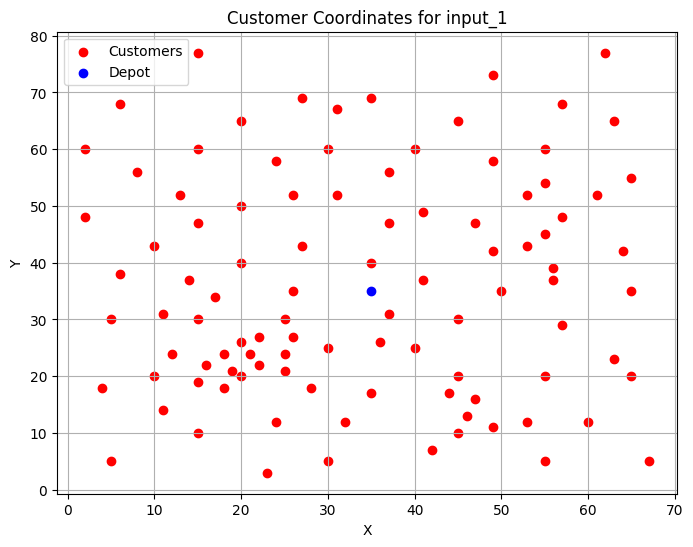

In [169]:
x_input1 = [x["x"] for x in input1]
y_input1 = [x["y"] for x in input1]

x_input2 = [x["x"] for x in input2]
y_input2 = [x["y"] for x in input2]

x_input3 = [x["x"] for x in input3]
y_input3 = [x["y"] for x in input3]


plot_customers(x_input1, y_input1, "input_1")

In [37]:
#Best solution routes 
def plot_best_solution(x, title):
    plt.figure(figsize=(8, 6))
    routes = x.get_routes()
    for route in routes:
        x_points  = np.array([x.depot["x"]])
        x_points = np.append(x_points, [x.data[i]["x"] for i in route], axis = 0)
        x_points = np.append(x_points, [x.depot["x"]], axis = 0)
        y_points  = np.array([x.depot["y"]])
        y_points = np.append(y_points, [x.data[i]["y"] for i in route], axis = 0)
        y_points = np.append(y_points, [x.depot["y"]], axis = 0) 

        plt.plot(x_points, y_points)
    
    plt.title(title)
    plt.show

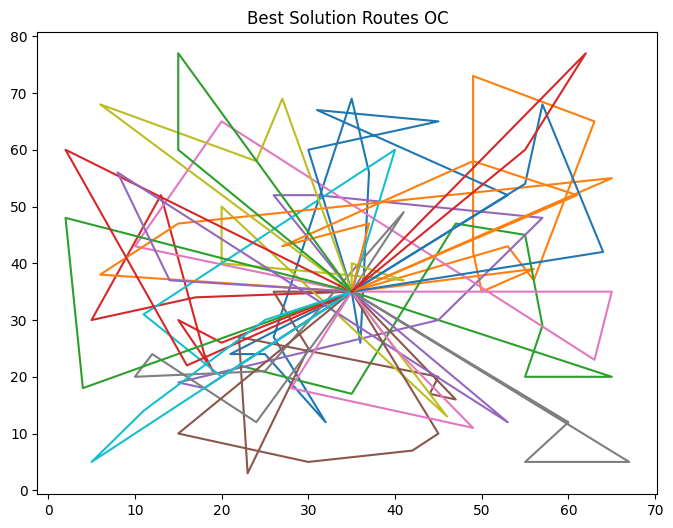

In [38]:
plot_best_solution(ga_order_crossover, "Best Solution Routes OC")
#plot_best_solution(ga_pmc, "Best Solution Routes PMX")
#plot_best_solution(ga_brbac, "Best Solution Routes BRBAC") 

In [40]:
def best_solution_evolution(solutions, title, info):
    plt.figure(figsize=(8, 6))
    y_points = [[] for _ in range(len(solutions))]
    i = 0
    for solution in solutions:
        y_points[i] = [x.fitness for x in solution]
        i+=1
    
    for i,y in enumerate(y_points):
        plt.plot(np.array(y), label = info[i])
    plt.title(title)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.legend()
    plt.show()

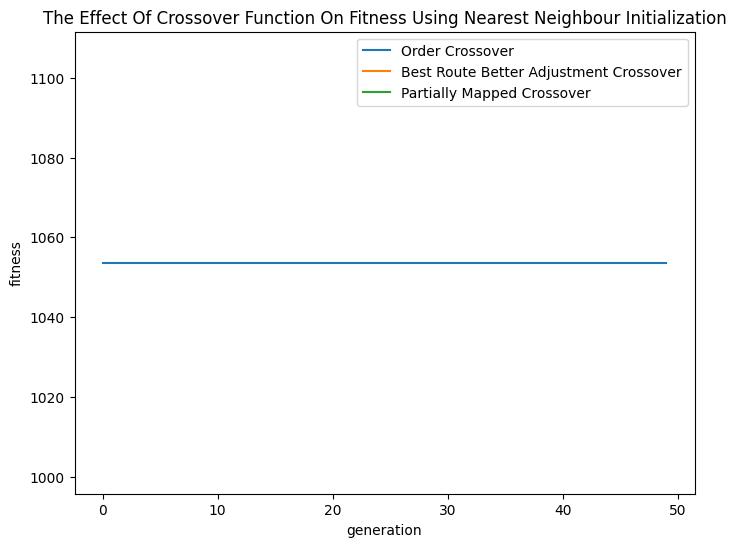

In [41]:
best_solution_evolution([best_solutions_order_crossover, [], []], "The Effect Of Crossover Function On Fitness Using Nearest Neighbour Initialization", ["Order Crossover", "Best Route Better Adjustment Crossover", "Partially Mapped Crossover"])